In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import archimedes as arc
from archimedes.experimental import coco as cc

arc.set_theme("dark")

%load_ext autoreload
%autoreload 2

In [2]:
# Dynamics function
def f(t, q, u, p):
    x, θ, ẋ, θ̇ = q
    m1, m2, L, g = 1.0, 0.3, 0.5, 9.81
    sθ, cθ = np.sin(θ), np.cos(θ)
    τ = u[0]
    den = m1 + m2 * sθ**2
    ẍ = (L * m2 * sθ * θ̇**2 + τ + m2 * g * cθ * sθ) / den
    θ̈ = -(L * m2 * cθ * sθ * θ̇**2 + τ * cθ + (m1 + m2) * g * sθ) / (L * den)
    return np.array([ẋ, θ̇, ẍ, θ̈], like=q)


# Running cost
def j(t, x, u, p):
    return u**2


# Total cost
def cost(x0, t0, xf, tf, q, p):
    return q


# Discretize the domain
N = [10, 10, 10, 10]
knots = [-0.5, 0.0, 0.5]
domain = cc.RadauFiniteElements(N=N, knots=knots)

t0, tf = 0.0, 2.0
x0 = np.array([0.0, 0.0, 0.0, 0.0])
xf = np.array([1.0, np.pi, 0.0, 0.0])
boundary_conditions = [
    cc.start_time(t0),
    cc.end_time(tf),
    cc.initial_condition(x0),
    cc.final_condition(xf),
]


# Define the optimal control problem
ocp = cc.OptimalControlProblem(
    nx=4,
    nu=1,
    ode=f,
    quad=j,
    cost=cost,
    boundary_constraints=boundary_conditions,
)


# Linearly interpolate initial guess
def x_guess(t):
    return x0 + (t - t0) * (xf - x0) / (tf - t0)


# Initialize the problem
sol = ocp.solve(domain, t_guess=(t0, tf), x_guess=x_guess)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     7170
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:      520

Total number of variables............................:      206
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      170
Total number of inequality c

(200, 4) (200,) (200,)
(200, 1) (200,) (200,)


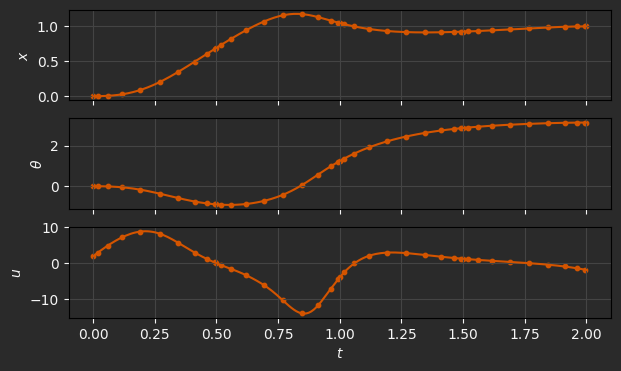

In [3]:
import matplotlib.pyplot as plt

t_plt = np.linspace(t0, tf, 200)
x_plt = sol.x(t_plt)
u_plt = sol.u(t_plt)

fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
ax[0].scatter(sol.tp, sol.xp[:, 0], s=10)
ax[0].plot(t_plt, x_plt[:, 0])
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].scatter(sol.tp, sol.xp[:, 1], s=10)
ax[1].plot(t_plt, x_plt[:, 1])
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[2].scatter(sol.tp[:-1], sol.up, s=10)
ax[2].plot(t_plt, u_plt)
ax[2].grid()
ax[2].set_ylabel(r"$u$")
ax[2].set_xlabel(r"$t$")

plt.show()

[]

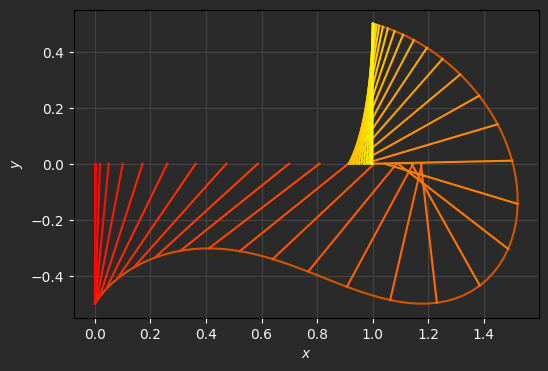

In [4]:
L = 0.5

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

xp = x_plt[:, 0] + L * np.sin(x_plt[:, 1])
yp = -L * np.cos(x_plt[:, 1])
ax.plot(xp, yp)

cmap = mpl.colormaps["autumn"]

stride = 5
for i in range(0, len(x_plt), stride):
    ax.plot([x_plt[i, 0], xp[i]], [0, yp[i]], c=cmap(i / len(x_plt)))

ax.grid()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.plot()